# Imports

In [4]:
# python peripherals
import random
import os
import sys
import math
from pathlib import Path

# numpy
import numpy

# pandas
import pandas

# ipython
from IPython.display import display, HTML

# matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.lines

# plotly
import plotly.express as px

# pytorch
import torch
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.sampler import SequentialSampler
from torch.utils.data import DataLoader
from torchvision import transforms

# wsi-mil
# os.chdir('./..')
sys.path.insert(1, os.path.join(sys.path[0], './..'))
from nn import datasets
import utils
from nn import trainers

# openslide
import openslide

# Learning Curve

0.3884486117839813
0.5646159460522094


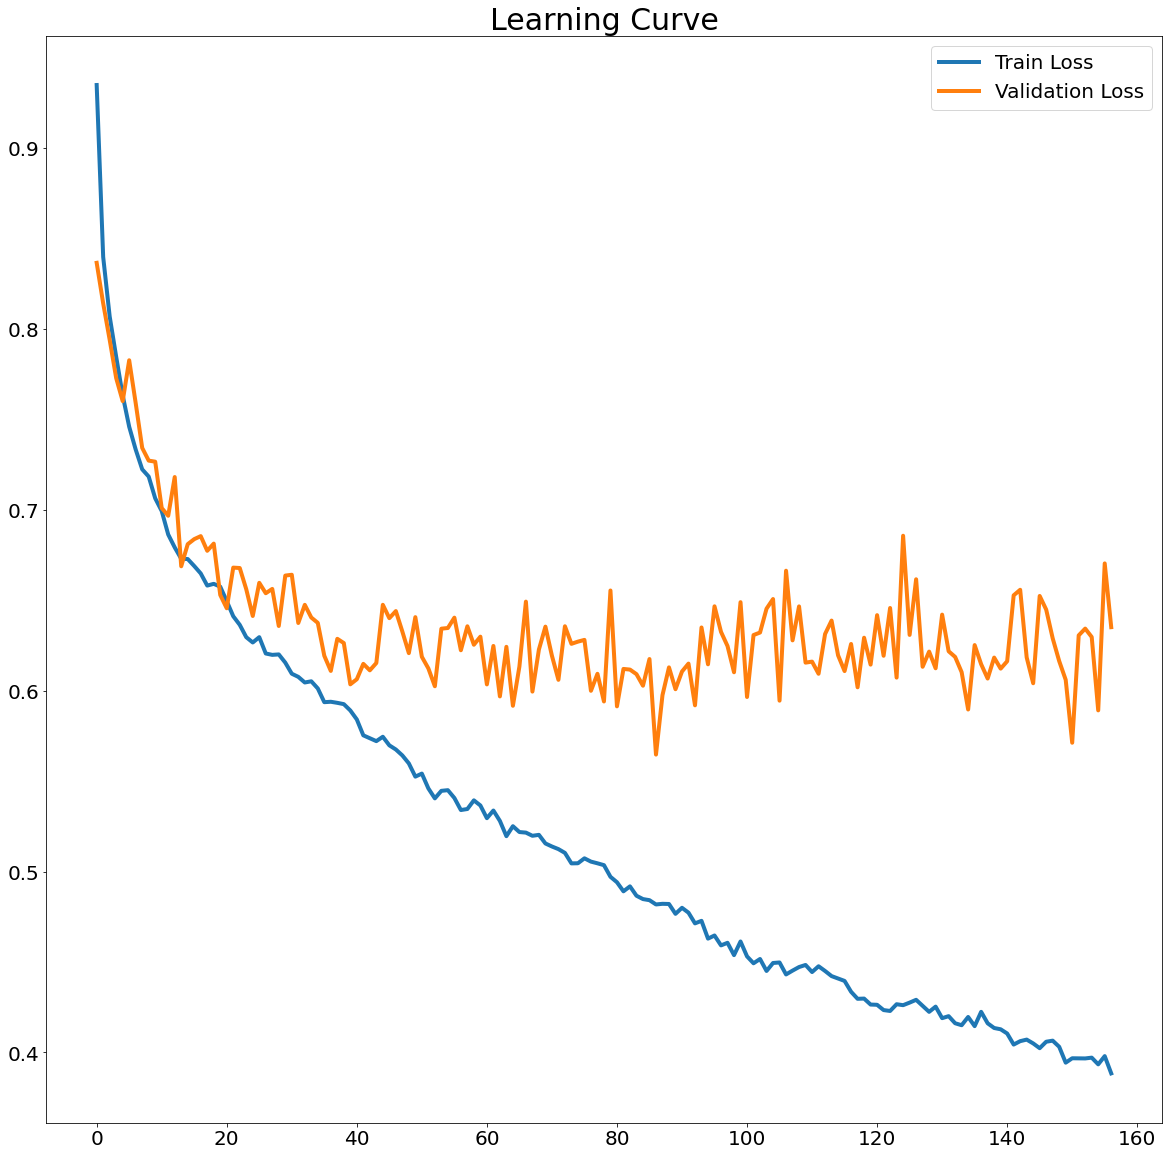

In [5]:
results_dir_path = 'C:/GitHub/WSI_MIL/results'

def plot_learning_curve(results_dir_path, title):
    latest_subdir = utils.get_latest_subdirectory(results_dir_path)
    results = numpy.load(f"{latest_subdir}/results.npy", allow_pickle=True).item()

    start_index = 0
    end_index = None
    train_loss_array = results['train_loss_array'][start_index:] if end_index is None else results['train_loss_array'][start_index:end_index]
    validation_loss_array = results['validation_loss_array'][start_index:] if end_index is None else results['validation_loss_array'][start_index:end_index]

    train_loss_array_no_nan = train_loss_array[~numpy.isnan(train_loss_array)]
    validation_loss_array_no_nan = validation_loss_array[~numpy.isnan(validation_loss_array)]

    epochs_list = numpy.array(range(len(train_loss_array)))

    fig, ax = plt.subplots(1, 1, figsize=(20,20))
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(20)

    ax.plot(epochs_list, train_loss_array, label='Train Loss', linewidth=4.0)
    ax.plot(epochs_list, validation_loss_array, label='Validation Loss', linewidth=4.0)
    ax.set_title(title, fontsize=30)

    plt.legend(fontsize=20, title_fontsize=20)

    print(numpy.min(train_loss_array_no_nan))
    print(numpy.min(validation_loss_array_no_nan))

    plt.show()

plot_learning_curve(results_dir_path, 'Learning Curve')

100%|██████████| 2590/2590 [00:05<00:00, 432.97it/s]


Worker Started 1 / 1
Item 30 / 30



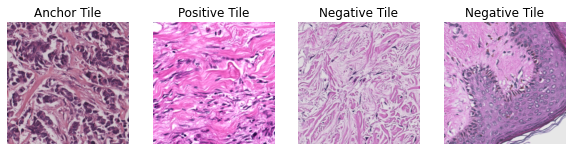

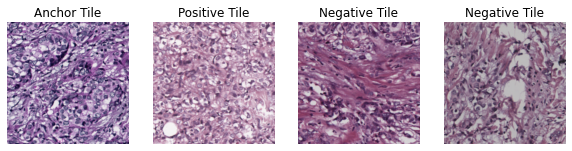

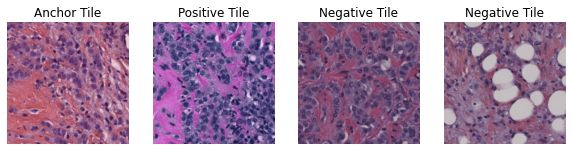

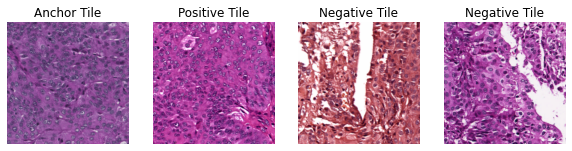

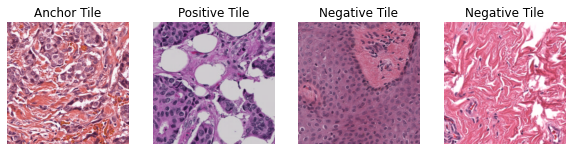

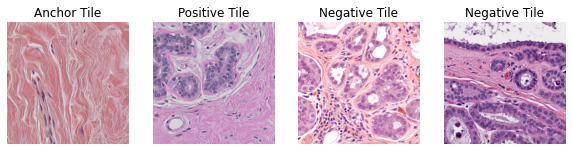

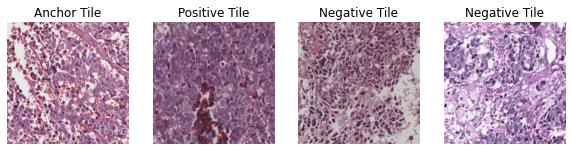

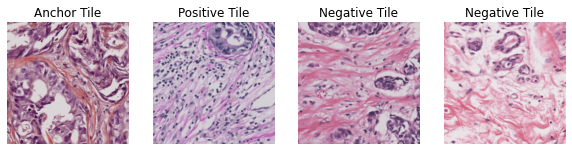

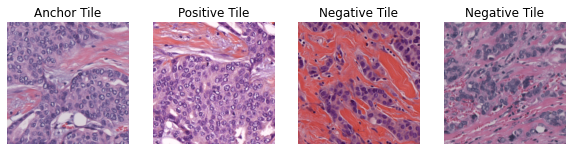

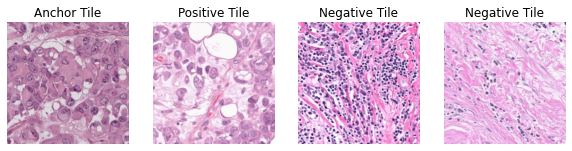

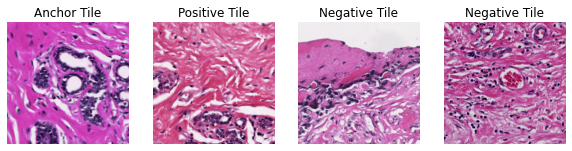

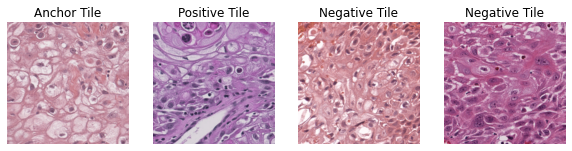

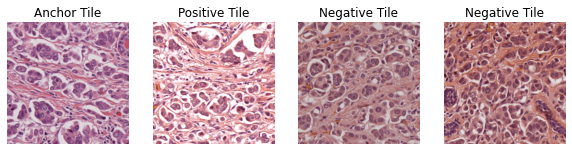

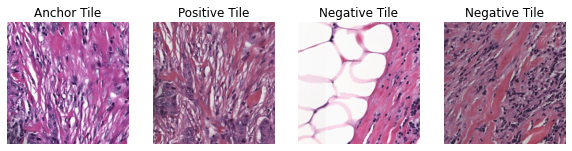

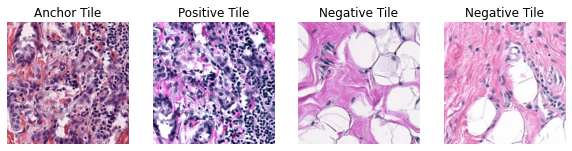

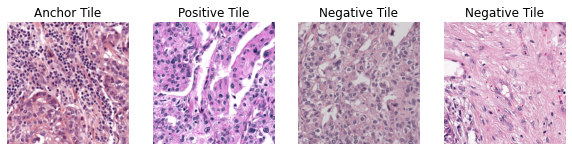

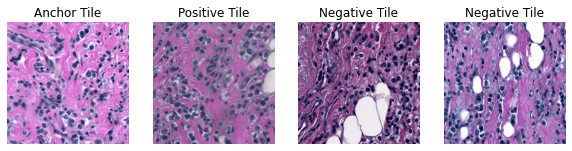

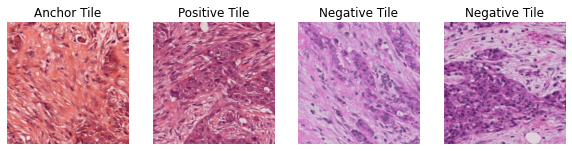

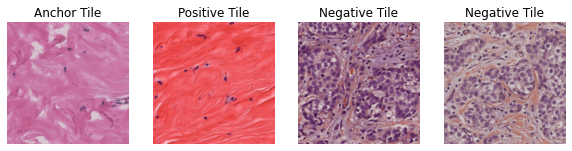

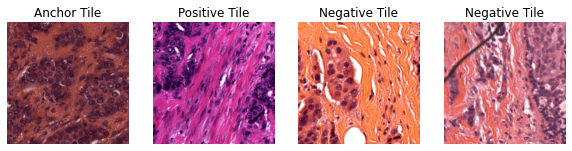

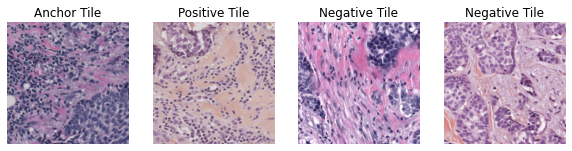

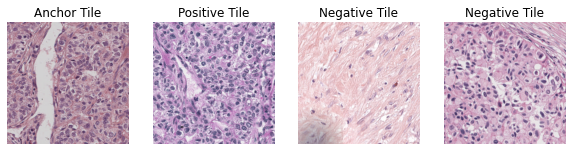

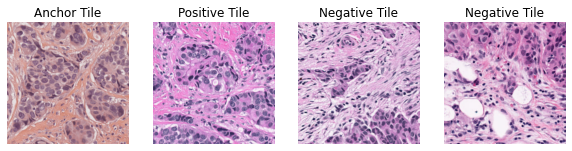

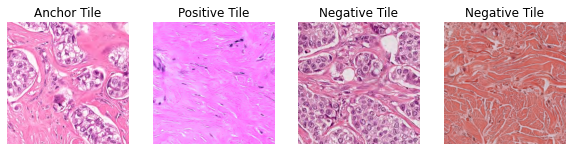

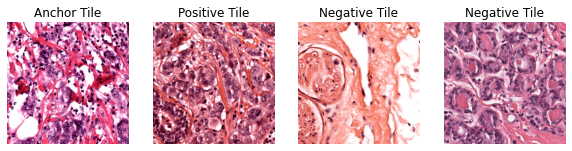

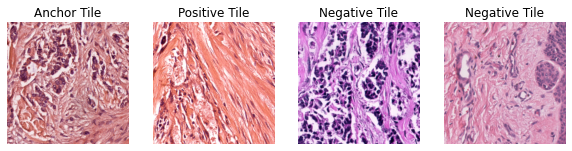

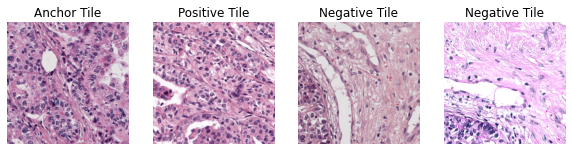

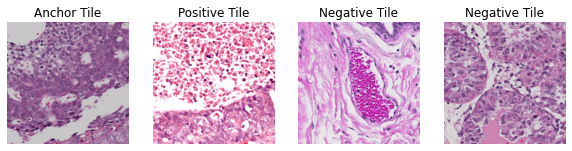

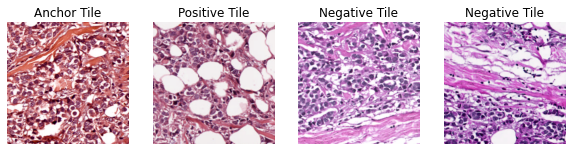

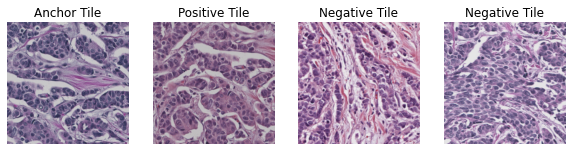

In [6]:
dataset_name = 'TCGA'
tile_size = 256
desired_magnification = 10
minimal_tiles_count = 10
test_fold = 1
datasets_base_dir_path = f'D:\Pathology'
negative_examples_count = 2
dataset_size = 30
batch_size = 4
buffers_base_dir = 'C:/GitHub/WSI_MIL/buffers'

train_dataset = datasets.WSIDistanceDataset(
    dataset_size=dataset_size,
    buffer_size=30,
    replace=True,
    num_workers=1,
    dataset_name=dataset_name,
    tile_size=tile_size,
    desired_magnification=desired_magnification,
    minimal_tiles_count=minimal_tiles_count,
    test_fold=test_fold,
    train=True,
    datasets_base_dir_path=datasets_base_dir_path,
    max_size=50,
    inner_radius=2,
    outer_radius=11)

# train_dataset.start(load_buffer=True, buffer_base_dir_path=buffers_base_dir)
train_dataset.start(load_buffer=False)

trainer = trainers.WSIDistanceModelTrainerTest()
indices = list(range(dataset_size))
sampler = SubsetRandomSampler(indices)
data_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, drop_last=False, num_workers=0)
for batch_index, batch_data in enumerate(data_loader, 0):
    preprocessed_input_features = trainer._preprocess_batch(batch_data=batch_data)
    output = preprocessed_input_features.reshape([batch_data['input_features'].shape[0], batch_data['input_features'].shape[1], 3, 256, 256])

    display(HTML(f'<H1>Batch {batch_index}'))

    for tuple_index in range(output.shape[0]):
        fig, axes = plt.subplots(nrows=1, ncols=2 + negative_examples_count, figsize=(10, 20))

        anchor_pic = transforms.ToPILImage()(output[tuple_index, 0, :, : ,:])
        positive_pic = transforms.ToPILImage()(output[tuple_index, 1, :, : ,:])

        axes[0].imshow(anchor_pic)
        axes[0].axis('off')
        axes[0].set_title('Anchor Tile')
        axes[1].imshow(positive_pic)
        axes[1].axis('off')
        axes[1].set_title('Positive Tile')

        for i in range(2,negative_examples_count + 2):
            negative_pic = transforms.ToPILImage()(output[tuple_index, i, :, : ,:])
            axes[i].imshow(negative_pic)
            axes[i].axis('off')
            axes[i].set_title('Negative Tile')

        plt.show()

train_dataset.stop()